In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import cftime
import datetime
import sys


In [2]:
times = xr.cftime_range(start="1980-01-01", end="1999-12-31", freq="3H", calendar="proleptic_gregorian", name="time")
#values = np.ones((len(times),5,4)) * 5 # allfives
#values = np.random.randint(0, high=6, size=(len(times),5,4)) # randint
#values = np.ones((len(times),5,4)); values[:,0:2,] = 2.2 # splitgrid
#values = np.ones((len(times),5,4)) * np.arange(1,len(times)+1).reshape(len(times),1,1) # inctime
values = np.random.randint(30,100,size=(len(times),5,4))
fake_xr_lowres = xr.Dataset({'TS': xr.DataArray(
                    data   = values,   # enter data here
                    dims   = ['time',"lat","lon"],
                    coords = {'time': times, "lat": np.arange(0.5,5.5), "lon": np.arange(1,5)},
                    attrs  = {
                        '_FillValue': -999.9,
                        'units'     : ''
                        }
                    )})
fake_xr_lowres.to_netcdf("test_data/lowres_ts_rand_1980-1999.nc")

In [3]:
ds = xr.open_dataset("test_data/lowres_ts_rand_1980-1999.nc")

In [4]:
year_beg = ds.isel({"time": 0}).time.dt.year.item()
year_end = ds.isel({"time": -1}).time.dt.year.item()
cal = ds.time.encoding["calendar"]

### Monthly

In [37]:
TXx_monthly = ds.resample(time='1D').max(dim="time").groupby("time.month").max()
TXn_monthly = ds.resample(time='1D').max(dim="time").groupby("time.month").min()
TNx_monthly = ds.resample(time='1D').min(dim="time").groupby("time.month").max()
TNn_monthly = ds.resample(time='1D').min(dim="time").groupby("time.month").min()

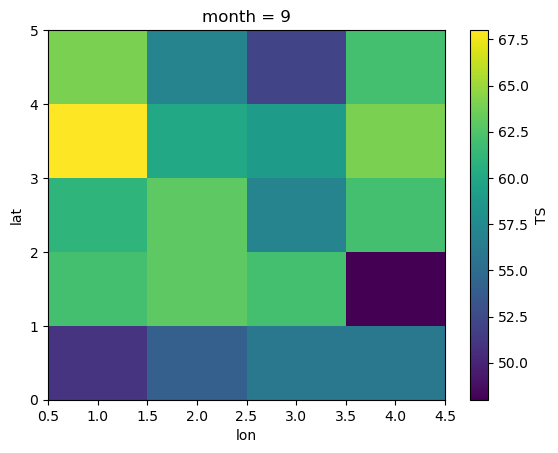

In [48]:
TXn.isel({"month":8}).TS.plot()

### Seasonal

In [82]:
# More calendar aware seasonal values
drop_incomplete_djf = True
if drop_incomplete_djf:
    new_start=cftime.datetime(year_beg,3,1,calendar=cal).strftime().strip("00:00:00")#-datetime.timedelta(days=0)
    new_end=(cftime.datetime(year_end,12,1,calendar=cal)-datetime.timedelta(days=1)).strftime().strip("00:00:00")
    ds_seasonal = ds.sel(time=slice(new_start, new_end))
else:
    ds_seasonal = ds
    
# get max/min value every day, then max/min value by season
TXx_seasonal = ds_seasonal.resample(time='1D').max(dim="time").groupby("time.season").max()
TXn_seasonal = ds_seasonal.resample(time='1D').max(dim="time").groupby("time.season").min()
TNx_seasonal = ds_seasonal.resample(time='1D').min(dim="time").groupby("time.season").max()
TNn_seasonal = ds_seasonal.resample(time='1D').min(dim="time").groupby("time.season").min()

In [98]:
ds.resample(time='1D').max(dim="time").time.encoding

{}

In [5]:
def get_seasonal_max(ds,season,cal,dec_mode="DJF",drop_incomplete_djf=True):

    year_beg = ds.isel({"time": 0}).time.dt.year.item()
    year_end = ds.isel({"time": -1}).time.dt.year.item()

    if year_end < year_beg + 1:
        print("Error: Final year must be greater than beginning year.")
        sys.exit(1)

    year_range = np.arange(year_beg,year_end+1,1)

    del_one_d = datetime.timedelta(days=1)
    del_zero_d = datetime.timedelta(days=0)

    dates = {
        "MAM": [(3,1), (6,1)],
        "JJA": [(6,1), (9,1)],
        "SON": [(9,1), (12,1)]
    }

    if season == "DJF" and dec_mode =="DJF":
        ds_max = ds.resample(time='QS-DEC').max(dim="time")
        ds_max = ds_max.isel(time=ds_max.time.dt.month.isin([12])) # djf will be in month "12" after resample
        if drop_incomplete_djf:
            ds_max = ds_max.sel(time=slice(str(year_beg),str(year_end-1)))
            ds_max["time"] = np.arange(year_beg+1,year_end+1)
        else:
            ds_max = ds_max.sel(time=slice(str(year_beg-1),str(year_end)))
            ds_max["time"] = np.arange(year_beg,year_end+2)
    elif season == "DJF" and dec_mode == "JFD":
        date_range_1 = [xr.cftime_range(start=cftime.datetime(year,1,1,calendar=cal)-del_zero_d,
                        end=cftime.datetime(year,3,1,calendar=cal)-del_one_d,
                        freq='D',
                        calendar=cal) for year in year_range]
        date_range_1 = [item for sublist in date_range_1 for item in sublist]
        date_range_2 = [xr.cftime_range(start=cftime.datetime(year,12,1,calendar=cal)-del_zero_d,
                        end=cftime.datetime(year+1,1,1,calendar=cal)-del_one_d,
                        freq='D',
                        calendar=cal) for year in year_range]
        date_range_2 = [item for sublist in date_range_2 for item in sublist]
        date_range = sorted(date_range_1 + date_range_2)
        ds_max = ds.sel(time=date_range).groupby("time.year").max(dim="time")
        ds_max = ds_max.rename({"year": "time"})
    else:
        mo_st = dates[season][0][0]
        day_st = dates[season][0][1]
        mo_en = dates[season][1][0]
        day_en = dates[season][1][1]
        date_range = [xr.cftime_range(start=cftime.datetime(year,mo_st,day_st,calendar=cal)-del_zero_d,
                              end=cftime.datetime(year,mo_en,day_en,calendar=cal)-del_one_d,
                              freq='D',
                              calendar=cal) for year in year_range]
        date_range = [item for sublist in date_range for item in sublist]
        ds_max = ds.sel(time=date_range).groupby("time.year").max(dim="time")
        ds_max = ds_max.rename({"year": "time"})  
    print(ds_max)
    
get_seasonal_max(ds.resample(time='1D').min(dim="time"),"MAM","proleptic_gregorian")

<xarray.Dataset>
Dimensions:  (lat: 5, lon: 4, time: 20)
Coordinates:
  * lat      (lat) float64 0.5 1.5 2.5 3.5 4.5
  * lon      (lon) int64 1 2 3 4
  * time     (time) int64 1980 1981 1982 1983 1984 ... 1995 1996 1997 1998 1999
Data variables:
    TS       (time, lat, lon) float64 71.0 68.0 63.0 60.0 ... 57.0 70.0 61.0


In [51]:
class SeasonalAverager():
    def __init__(self, ds, ds_var, dec_mode="DJF", drop_incomplete_djf=True, annual_strict=True):
        self.ds = ds
        self._set_years()
        self._set_calendar()
        self.dec_mode = dec_mode
        self.drop_incomplete_djf = drop_incomplete_djf
        self.annual_strict = annual_strict
        self.del_one_d = datetime.timedelta(days=1)
        self.del_zero_d = datetime.timedelta(days=0)
        self.ds_var = ds_var
    
    def _set_years(self):
        self.year_beg = self.ds.isel({"time": 0}).time.dt.year.item()
        self.year_end = self.ds.isel({"time": -1}).time.dt.year.item()

        if year_end < year_beg + 1:
            print("Error: Final year must be greater than beginning year.")
            sys.exit(1)

        self.year_range = np.arange(year_beg,year_end+1,1)
        
    def _set_calendar(self):
        self.calendar = self.ds.time.encoding["calendar"]
        
    def rolling(self):
        # Use on daily data
        return self.ds[self.ds_var].rolling(time=5).mean()
    
    def daily_total(self):
        # Use on sub-daily data
        return  self.ds.resample(time='1D').sum(dim="time")
    
    def daily_min(self):
        # Use on sub-daily data
        return  self.ds.resample(time='1D').min(dim="time")
        
    def daily_max(self):
        # Use on sub-daily data
        return self.ds.resample(time='1D').max(dim="time")
        
    def annual_stats(self,ds1,stat):
        if self.annual_strict:
            # Only use data from that year - start on Jan 5 avg
            date_range = [xr.cftime_range(
                            start=cftime.datetime(year,1,5,calendar=self.calendar)-self.del_zero_d,
                            end = cftime.datetime(year+1,1,1,calendar=self.calendar)-self.del_one_d,
                            freq='D',
                            calendar=self.calendar) for year in self.year_range]
            date_range = [item for sublist in date_range for item in sublist]
            if stat=="max":
                ds_ann = ds1.sel(time=date_range).groupby("time.year").max(dim="time")
            elif stat=="min":
                ds_ann = ds1.sel(time=date_range).groupby("time.year").min(dim="time")
        else:
            # Mean can include rolling data from past year
            if stat=="max":
                ds_ann = ds1.groupby("time.year").max(dim="time")
            elif stat=="min":
                ds_ann = ds1.groupby("time.year").min(dim="time")
            ds_ann = ds_ann.rename({"year": "time"})
        return ds_ann

    def seasonal_stats(self,ds1,season,stat):
        # Seasons can be "DJF","MAM","JJA","SON"
        # Stat can be "max", "min"

        if season == "DJF" and self.dec_mode =="DJF":
            # Resample DJF to count prior DJF in current year
            if stat == "max":
                ds_stat = ds.resample(time='QS-DEC').max(dim="time")
            elif stat=="min":
                ds_stat = ds.resample(time='QS-DEC').min(dim="time")

            ds_stat = ds_stat.isel(time=ds_stat.time.dt.month.isin([12]))
            
            if self.drop_incomplete_djf:
                ds_stat = ds_stat.sel(time=slice(str(self.year_beg),str(self.year_end-1)))
                ds_stat["time"] = np.arange(self.year_beg+1,self.year_end+1)
            else:
                ds_stat = ds_stat.sel(time=slice(str(self.year_beg-1),str(self.year_end)))
                ds_stat["time"] = np.arange(self.year_beg,self.year_end+2)
    
        elif season == "DJF" and self.dec_mode == "JFD":
            # Make date lists that capture JF and D in all years, then merge and sort
            date_range_1 = [xr.cftime_range(
                                start=cftime.datetime(year,1,1,calendar=self.calendar)-self.del_zero_d,
                                end=cftime.datetime(year,3,1,calendar=self.calendar)-self.del_one_d,
                                freq='D',
                                calendar=cal) for year in self.year_range]
            date_range_1 = [item for sublist in date_range_1 for item in sublist]
            date_range_2 = [xr.cftime_range(
                                start=cftime.datetime(year,12,1,calendar=self.calendar)-self.del_zero_d,
                                end=cftime.datetime(year+1,1,1,calendar=self.calendar)-self.del_one_d,
                                freq='D',
                                calendar=cal) for year in self.year_range]
            date_range_2 = [item for sublist in date_range_2 for item in sublist]
            date_range = sorted(date_range_1 + date_range_2)
            
            if stat=="max":
                ds_stat = ds.sel(time=date_range).groupby("time.year").max(dim="time")
            elif stat=="min":
                ds_stat = ds.sel(time=date_range).groupby("time.year").min(dim="time")
            ds_stat = ds_stat.rename({"year": "time"})
        
        else:  # Other 3 seasons
            dates = { # Month/day tuples
                "MAM": [(3,1), (6,1)],
                "JJA": [(6,1), (9,1)],
                "SON": [(9,1), (12,1)]
            }
            
            mo_st = dates[season][0][0]
            day_st = dates[season][0][1]
            mo_en = dates[season][1][0]
            day_en = dates[season][1][1]
            
            date_range = [xr.cftime_range(
                            start=cftime.datetime(year,mo_st,day_st,calendar=self.calendar)-self.del_zero_d,
                            end=cftime.datetime(year,mo_en,day_en,calendar=self.calendar)-self.del_one_d,
                            freq='D',
                            calendar=self.calendar) for year in self.year_range]
            date_range = [item for sublist in date_range for item in sublist]
            
            if stat=="max":
                ds_stat = ds.sel(time=date_range).groupby("time.year").max(dim="time")
            elif stat=="min":
                ds_stat = ds.sel(time=date_range).groupby("time.year").min(dim="time")
            ds_stat = ds_stat.rename({"year": "time"})  
            
        return ds_stat

In [41]:
S = SeasonalAverager(ds,"TS")

In [37]:
%%time
smax = S.daily_max()
smin = S.daily_min()
S.annual_stats(smax,"max")
S.annual_stats(smax,"min")
S.annual_stats(smin,"max")
S.annual_stats(smin,"min")

<xarray.Dataset>
Dimensions:  (lat: 5, lon: 4, year: 20)
Coordinates:
  * lat      (lat) float64 0.5 1.5 2.5 3.5 4.5
  * lon      (lon) int64 1 2 3 4
  * year     (year) int64 1980 1981 1982 1983 1984 ... 1995 1996 1997 1998 1999
Data variables:
    TS       (year, lat, lon) float64 30.0 30.0 30.0 30.0 ... 30.0 30.0 30.0

In [38]:
S.seasonal_stats(smax,"DJF","max")

<xarray.Dataset>
Dimensions:  (lat: 5, lon: 4, time: 19)
Coordinates:
  * lat      (lat) float64 0.5 1.5 2.5 3.5 4.5
  * lon      (lon) int64 1 2 3 4
  * time     (time) int64 1981 1982 1983 1984 1985 ... 1995 1996 1997 1998 1999
Data variables:
    TS       (time, lat, lon) float64 99.0 99.0 99.0 99.0 ... 99.0 99.0 99.0

In [44]:
%%time
sr = S.rolling()
S.seasonal_stats(sr,"DJF","max");
S.seasonal_stats(sr,"MAM","max");
S.seasonal_stats(sr,"JJA","max");
S.seasonal_stats(sr,"SON","max");

CPU times: user 723 ms, sys: 13.9 ms, total: 737 ms
Wall time: 738 ms


In [48]:
ds=xr.load_dataset("test_data/hires_modelC_1995-1999.nc",chunks={"lat":32,"lon":32})

In [49]:
%%time
S = SeasonalAverager(ds,"pr")
smax = S.daily_max()
smin = S.daily_min()

CPU times: user 1min 9s, sys: 2min 1s, total: 3min 11s
Wall time: 3min 11s


In [52]:
%%time
sr = S.rolling()


CPU times: user 1min 25s, sys: 18.8 s, total: 1min 44s
Wall time: 1min 44s


In [53]:
%%time
S.seasonal_stats(sr,"DJF","max");
S.seasonal_stats(sr,"MAM","max");
S.seasonal_stats(sr,"JJA","max");
S.seasonal_stats(sr,"SON","max");

ValueError: conflicting sizes for dimension 'time': length 19 on 'time' and length 5 on {'lat': 'lat', 'lon': 'lon', 'time': 'pr'}